# 06. 회귀진단 실습

김보람  
2023-05-06

> 해당 자료는 전북대학교 이영미 교수님 2023응용통계학 자료임

# 회귀진단

## Leverage vs. Outlier vs. Influence

In [1]:
library(lmtest)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
dt <- data.frame(x = c(15,26,10,9,15,20,18,11,
 8,20,7,9,10,11,11,10,12,42,17,11,10),
 y = c(95,71,83,91,102,87,93,100,
 104,94,113,96,83,84,102,100,
 105,57,121,86,100))

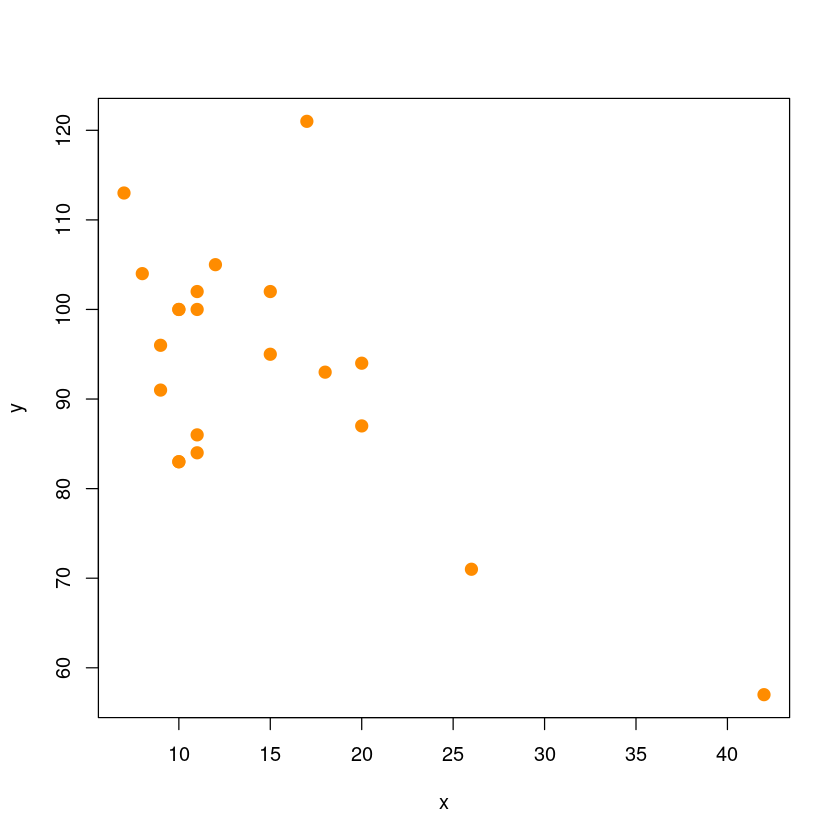

In [3]:
######## 산점도
plot(y~x, dt,pch = 20,cex = 2,col = "darkorange")

-   27이하로 normal하게 분포되어있는 데이터

## 회귀모형 적합: $y=\beta_0+ \beta_1x + \epsilon$

In [4]:
######## 회귀적합
model_reg <- lm(y~x, dt)
summary(model_reg)

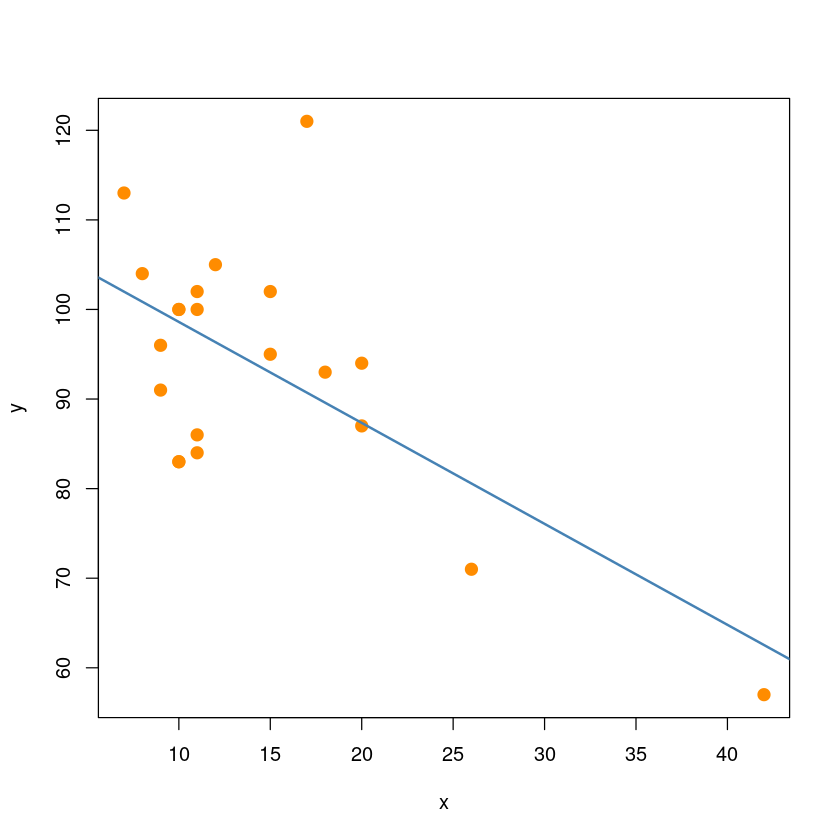

In [5]:
plot(y~x, dt,pch = 20,cex = 2,col = "darkorange")
abline(model_reg, col='steelblue', lwd=2)

## Hat Matrix

In [6]:
X = cbind(rep(1, nrow(dt)), dt$x)
H = X %*% solve(t(X) %*% X) %*% t(X)
diag(H)

-   21x21행렬

-   `0.0628157755825353` 18번쨰가 큰값을 가지고 있음. leverage일 확률이
    크다.

In [7]:
sum(diag(H))

-   $\sum h_{ii} = p+1 = 2$

In [8]:
hatvalues(model_reg)

> hatvalues는 $h_{ii}$값 바로 나오게 하는 함수

In [46]:
which.max(hatvalues(model_reg))  # 가장 큰 값의 번호
hatvalues(model_reg)[which.max(hatvalues(model_reg))] ##h_{18,18}값

In [10]:
2*(1+1)/nrow(dt)

> $h_{18,18} > 2 \bar h=2 \dfrac{p+1}{n}=2\dfrac{2}{21}=0.19047619047619$이므로
> 18번째 관측값이 leverage point 로 고려 가능

In [47]:
hatvalues(model_reg)>0.19047619047619

> 0.19047619047619보다 큰값이 있다면 leverage point

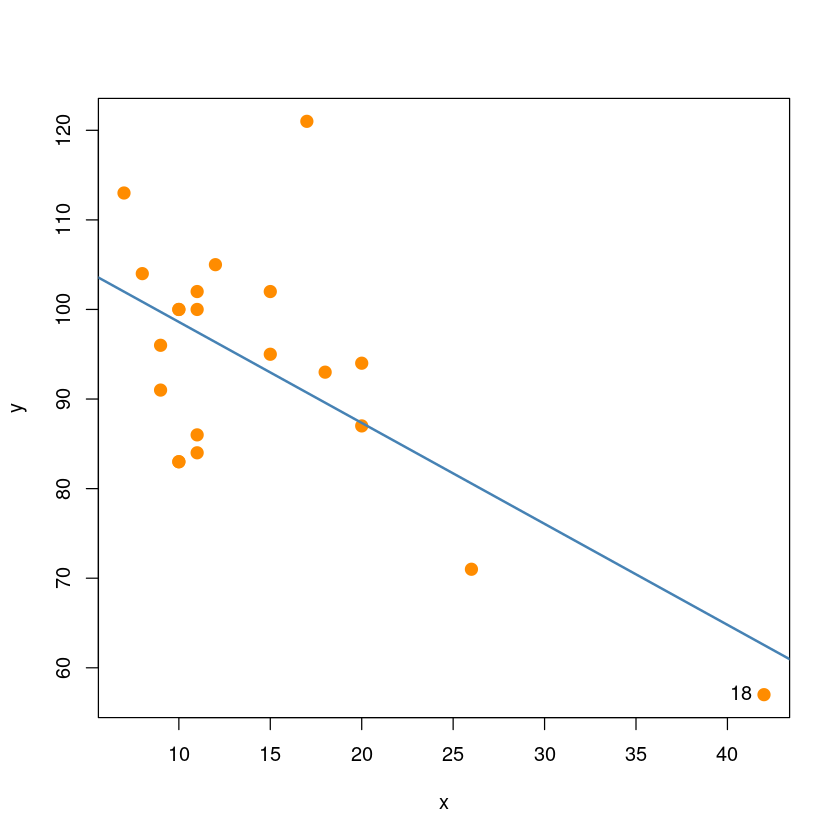

In [11]:
plot(y~x, dt,pch = 20,cex = 2,col = "darkorange")
text(dt[18,],"18", pos=2)
abline(model_reg, col='steelblue', lwd=2)

## 이상치

### 잔차: $e_i = y_i - \hat y_i$

In [12]:
residual <- model_reg$residuals
head(residual)

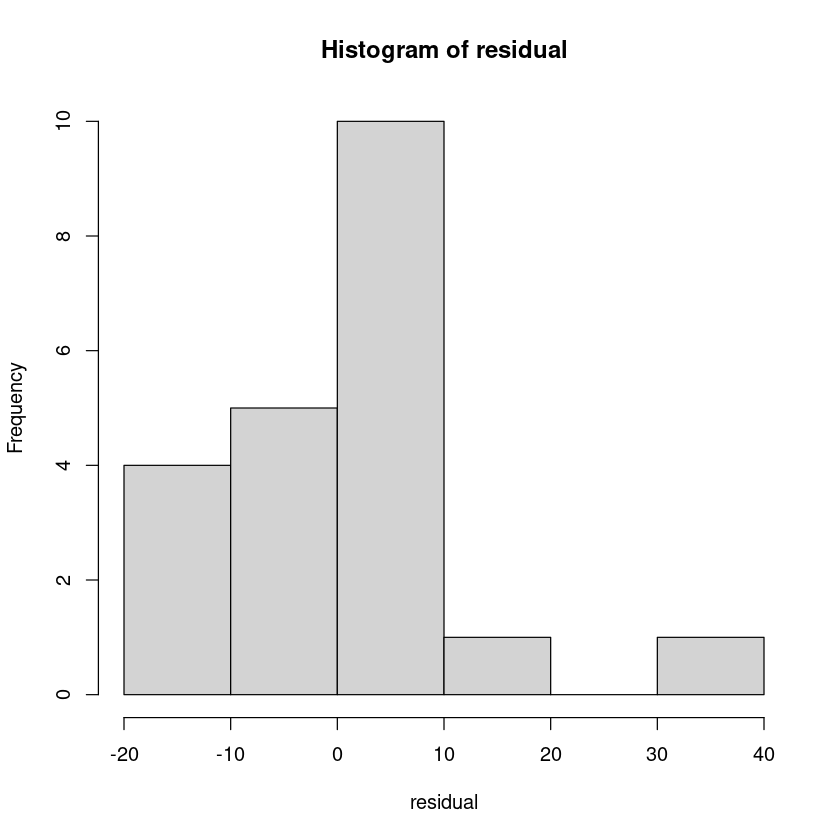

In [13]:
hist(residual)

-   1개의 관측값이 30~40 사이에 있다. 혼자 동떨어져있는 값

### 내적으로 표준화된 잔차 ((internally) standardized residual)

$$r_i = \dfrac{e_i}{\hat \sigma \sqrt{1-h_{ii}}}$$  
아마도$N(0,1)$을 따를거야. 하지만 $\hat \sigma$이므로 완벽한 정규분포는
아니고 그렇다면 t분포냐? 독립이 아니므로 t분포가 아니다. N이 충분히
크다면 대략적으로 정규분포를 따른다고 볼 수 있다.

$e_i$ ~ $N(0,\sigma^2(1-h_{ii}))$

-   $|r_i| \geq 2$ OR $|r_i| \geq 3$이면 이상치

In [14]:
s_residual <- rstandard(model_reg)
head(s_residual)


In [50]:
# 또는
s_xx <- sum((dt$x-mean(dt$x))^2) #S_xx
h_ii <- 1/21 + (dt$x- mean(dt$x))^2/s_xx #hatvalues로 구해도 됨. 혹은 X(X^TX)-1X^T로 해도 됨
### h_ii <- hatvalues(model_reg)
### h_ii <- influence(model_reg)$hat
hat_sigma <- summary(model_reg)$sigma #hat sigma
s_residual <- resid(model_reg)/(hat_sigma*sqrt(1-h_ii)) ## 내적

-   $h_{ii}=\dfrac{1}{n}+\dfrac{(x_i-\bar x)^2}{S_{xx}}$

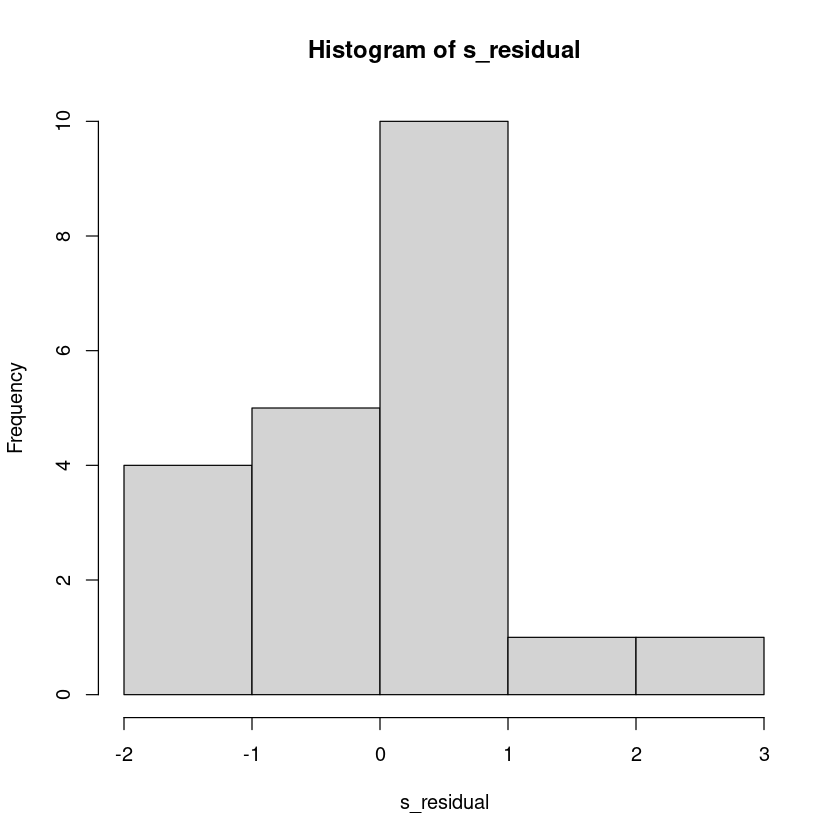

In [16]:
hist(s_residual)

-   똑같은 모양인데 scaleing시켜서 0근처에서 움직이도록. 2나 3보다 크면
    이상치라고 했으니 맨오른쪽에 있는 관측값이 이상치일 듯. 근데 약간
    몰려있어서 애매해.

### 외적으로 표준화된 잔차 ((externally) standardized residual)

$$r_i^* = \dfrac{e_i}{\hat \sigma_i \sqrt{1-h_{ii}}}$$  
$t(n-p-2)=(n-1-p-1)$

$\hat \sigma_i : i$번째 측정값 $y_i$를 제외하고 얻어진 $\hat \sigma$

$\hat \sigma_i^2 = \left[ (n-p-1) \hat \sigma^2 - \dfrac{e_i^2}{1-h_{ii}} \right] / (n-p-2)$

$|r_i^*| \geq t_{\alpha/2}(n-p-2)$이면 이상치

In [17]:
s_residual_i <- rstudent(model_reg)
head(s_residual_i)

In [18]:
# 또는
hat_sigma_i <- sqrt(((21-1-1)*hat_sigma^2 - residual^2/(1-h_ii) )/(21-1-2))
## hat_sigma_i <- influence(model_reg)$sigma
s_residual_i <- residual/(hat_sigma_i*sqrt(1-h_ii)) ## 외적

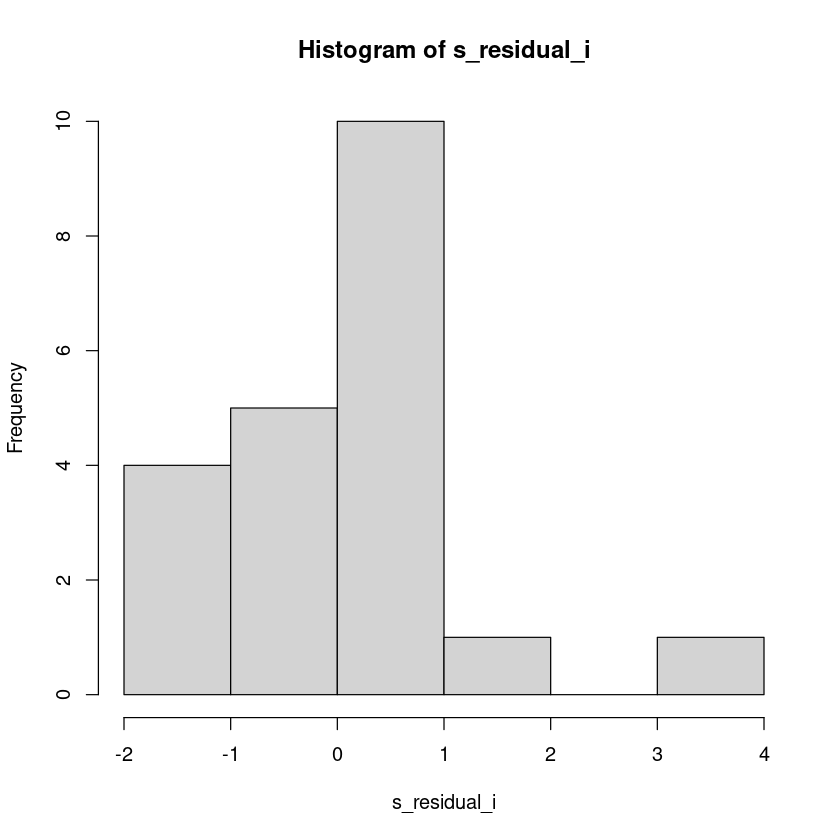

In [19]:
hist(s_residual_i)

-   둥 떨어져있는 맨 오른쪽 관측값

In [21]:
which.max(s_residual_i)
s_residual_i[which.max(s_residual_i)]

In [22]:
qt(0.975, 21-1-2)

$t_{0.025}(21-1-1) : \alpha=5\%$

$|r_i^*| \geq t_{\alpha/2}(n-p-2)$이면, 유의수준 $\alpha$에서, $i$번째
관측값이 이상점이라고 할 수 있다.

따라서 19번째 관측값은 유의수준 0.05에서 이상점이라고 할 수 있다.

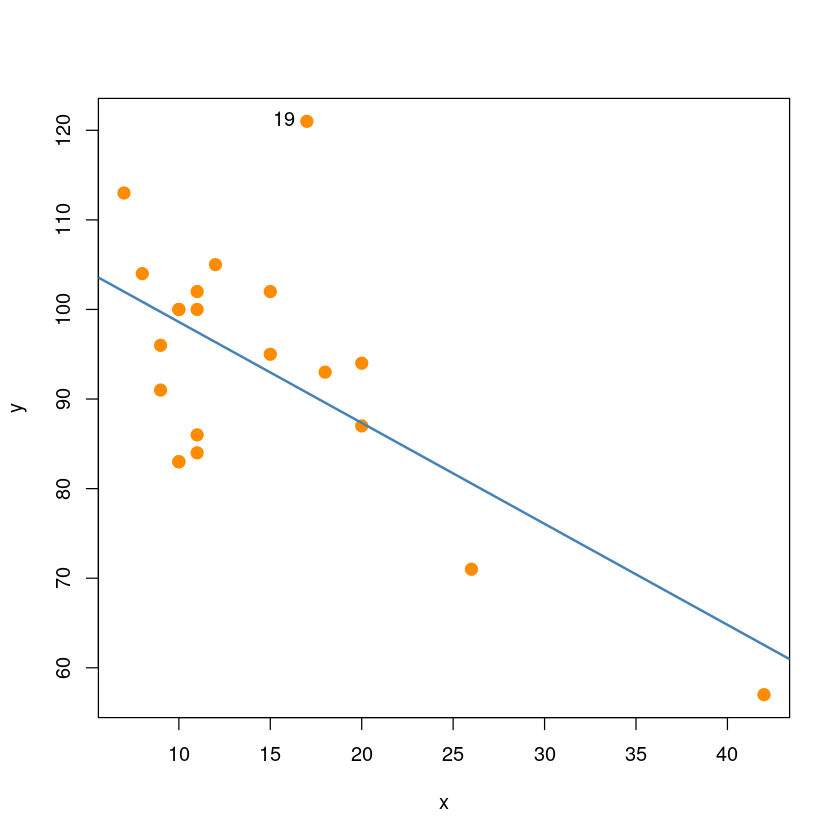

In [23]:
plot(y~x, dt,pch = 20,cex = 2,col = "darkorange")
text(dt[19,],"19", pos=2)
abline(model_reg, col='steelblue', lwd=2)

In [24]:
s_residual_i[which(abs(s_residual_i)>qt(0.975,21-2))]

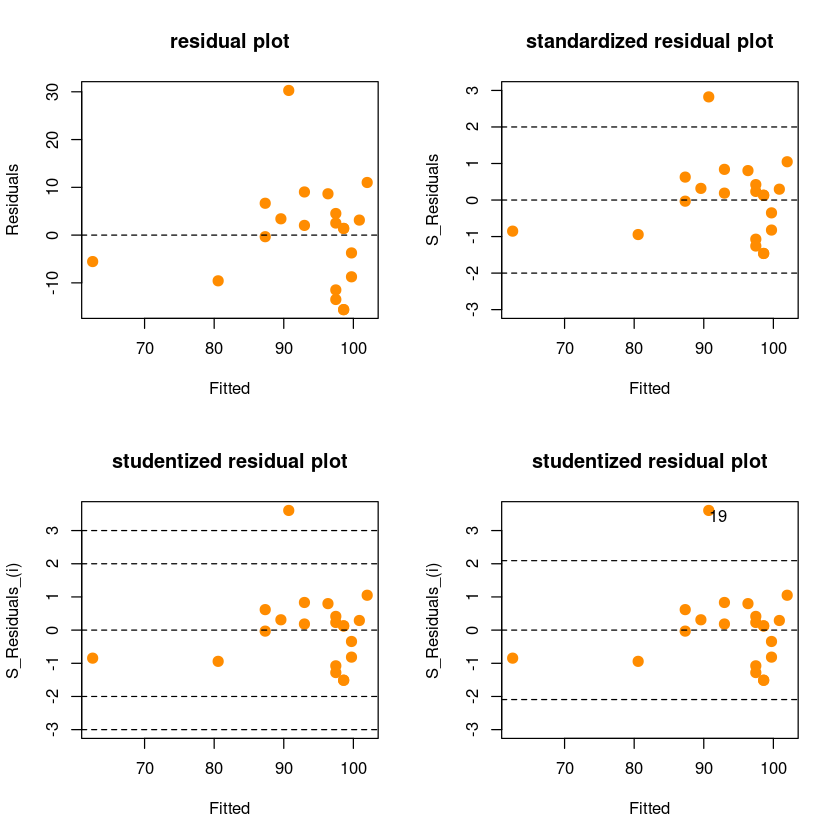

In [25]:
## 잔차그림
par(mfrow = c(2, 2))
plot(fitted(model_reg), residual,
 pch=20,cex = 2,col = "darkorange",
 xlab = "Fitted", ylab = "Residuals",
 main = "residual plot")
abline(h=0, lty=2)
plot(fitted(model_reg), s_residual,
 pch=20,cex = 2,col = "darkorange",
 xlab = "Fitted", ylab = "S_Residuals",
 ylim=c(min(-3, min(s_residual)),
 max(3,max(s_residual))),
 main = "standardized residual plot")
abline(h=c(-2,0,2), lty=2)
plot(fitted(model_reg), s_residual_i,
 pch=20,cex = 2,col = "darkorange",
 xlab = "Fitted", ylab = "S_Residuals_(i)",
 ylim=c(min(-3, min(s_residual_i)),
 max(3,max(s_residual_i))),
 main = "studentized residual plot")
abline(h=c(-3,-2,0,2,3), lty=2)
plot(fitted(model_reg), s_residual_i,
 pch=20,cex = 2,col = "darkorange",
 xlab = "Fitted", ylab = "S_Residuals_(i)",
 ylim=c(min(-3, min(s_residual_i)),
 max(3,max(s_residual_i))),
 main = "studentized residual plot")
abline(h=c(-qt(0.975,21-2),0,qt(0.975,21-2)), lty=2)
text (fitted(model_reg)[which(abs(s_residual_i)>qt(0.975,21-2))],
 s_residual_i[which(abs(s_residual_i)>qt(0.975,21-2))],
 which(abs(s_residual_i)>qt(0.975,21-2)),adj = c(0,1))

-   맨오른쪽 아래 그림은 $t_i^*$의 그림이고 점선은 위에는
    $t_{0.025}(21-2)$, 아래는 $-t_{0.025}(19)$

## 정규성 검정

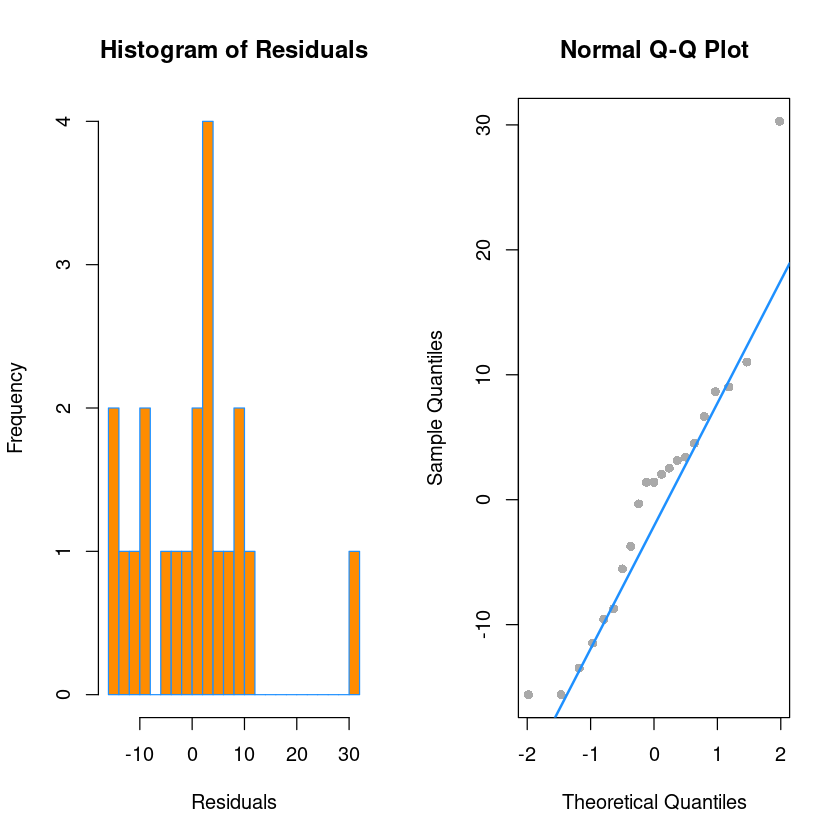

In [26]:
## 정규성 검정
par(mfrow=c(1,2))
hist(resid(model_reg),
 xlab = "Residuals",
 main = "Histogram of Residuals",
 col = "darkorange",
 border = "dodgerblue",
 breaks = 20)
qqnorm(resid(model_reg),
 main = "Normal Q-Q Plot",
 col = "darkgrey",
 pch=16)
qqline(resid(model_reg), col = "dodgerblue", lwd = 2)

-   Q-Q plot에서 꼬리가 하나가 길게 나옴-\>이상치

In [27]:
## Shapiro-Wilk Test
## H0 : normal distribution vs. H1 : not H0
shapiro.test(resid(model_reg))

-   기각할 수 없다. 정규분포이다.

In [28]:
## 독립성 검정
lmtest::dwtest(model_reg)

In [29]:
### 등분산성
## H0 : 등분산 vs. H1 : 이분산 (Heteroscedasticity)
bptest(model_reg)

## 영향점

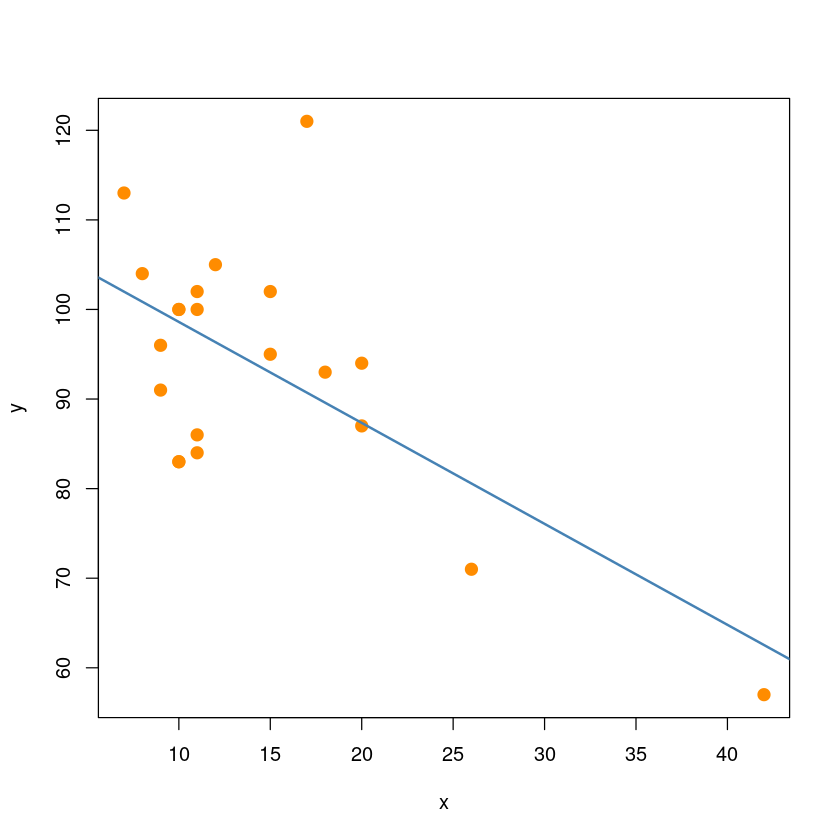

In [30]:
plot(y~x, dt,pch = 20,cex = 2,col = "darkorange")
abline(model_reg, col='steelblue', lwd=2)

In [31]:
influence(model_reg)

> -   `coefficients`: `(Intercept)`=$\beta_0$, `x`=$\beta_1$
>
> -   `0.001045618` = $\hat \beta_1 - \tilde \beta_1$ : (포함하여)21개로
>     돌린거랑 (1번째 변수빼고)20개로 돌린거의 차이값
>
> -   `-0.005167222` = $\hat \beta_1 - \tilde \beta_1$ :
>     (포함하여)21개로 돌린거랑 (21번째 변수빼고)20개로 돌린거의 차이값
>
> -   값이 크면 영향점으로 생각
>
> -   18번째 데이터가 살짝 커보인다.

> -   `$sigma` : $\hat \sigma_{(i)}$

> -   `$wt.res` : 신경쓰지말자

In [32]:
influence.measures(model_reg)

-   `dfb.1_ ,  dfb.x` :
    $(\hat \beta_1 - \tilde \beta_{1(i)})/$뭘로나누자

-   `inf` : 영향점인 것 같으면 \*로 표시

### DFFITS

-   DFFITS:
    $DFFITS(i) = \dfrac{\hat y_i - \tilde y_i(i)}{\hat \sigma_{(i)} \sqrt{h_{ii}}}$

-   $|DFFITS(i)| \geq 2 \sqrt{\dfrac{p+1}{n-p-1}}$이면 영향점

In [33]:
dffits(model_reg) 

In [34]:
which(abs(dffits(model_reg)) > 2*sqrt(2/(21-2)))

### Cook’s Distance

-   Cook’s Distance

-   $D(i) = \dfrac{\sum_{i=1}^n (\hat y_j - \hat y_j(i))^2}{(p+1)\hat \sigma^2}=\dfrac{(\hat \beta - \hat \beta(i))^T X^T X (\hat \beta - \hat \beta(i))}{(p+1) \hat \sigma^2}$

-   $\hat \beta(i): i$번째 관측치를 제외하고 $n-1$개의 관측값에서 구한
    $\hat \beta$의 최소제곱추저량

In [35]:
cooks.distance(model_reg)

-   $D(i) \geq F_{0.5}(p+1, n-p-1)$이면 영향점으로 의심

In [36]:
qf(0.5,2,21-2)

In [37]:
which(cooks.distance(model_reg) >qf(0.5,2,21-2))

없다!

### COVRATIO

-   COVRATIO

$COVRATIO(i) = \dfrac{1}{\left[1+\dfrac{(r_i^*)^2-1}{n-p-1}\right]^{p+1}(1-h_{ii})}$

$|COVRATIO(i)-1| \geq 3(p+1)/n$이면 $i$번째 관측치를 영향을 크게 주는
측정값으로 볼 수 있음

In [38]:
covratio(model_reg)

In [39]:
which(abs(covratio(model_reg)-1) > 3*(1+1)/21)

-   영향점

In [40]:
summary(influence.measures(model_reg))

Potentially influential observations of
     lm(formula = y ~ x, data = dt) :

   dfb.1_ dfb.x   dffit   cov.r   cook.d hat    
18  0.83  -1.11_* -1.16_*  2.96_*  0.68   0.65_*
19  0.14   0.27    0.85    0.40_*  0.22   0.05  

-   \*였떤 점만 뽑아서 보여줘ㅡ

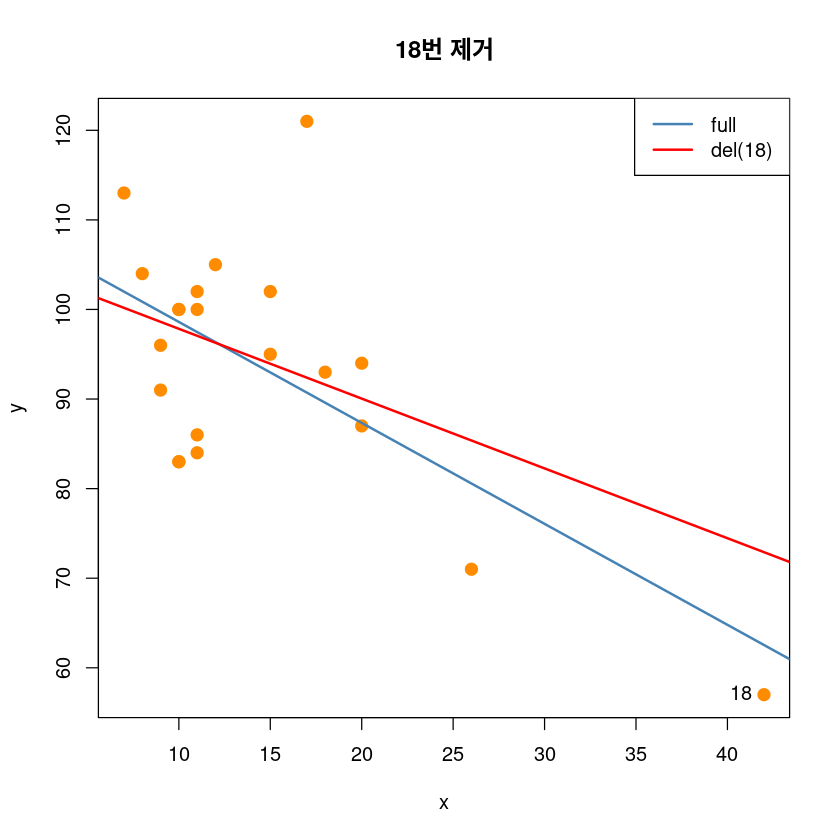

In [41]:
## 18제거 전후
plot(y~x, dt,pch = 20,
 cex = 2,col = "darkorange",
 main = "18번 제거")
abline(model_reg, col='steelblue', lwd=2)
abline(lm(y~x, dt[-18,]), col='red', lwd=2)
text(dt[18,], pos=2, "18")
legend('topright', legend=c("full", "del(18)"),
 col=c('steelblue', 'red'), lty=1, lwd=2)
# high leverage and high influence, not outlier

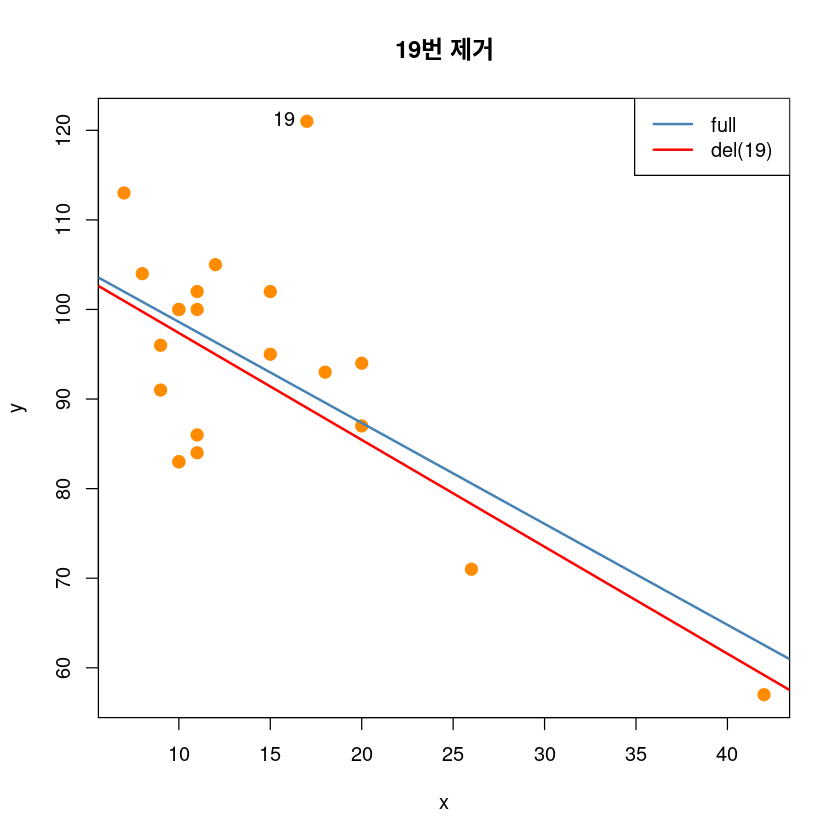

In [42]:
## 19제거 전후
plot(y~x, dt,pch = 20,
 cex = 2,col = "darkorange",
 main = "19번 제거")
abline(model_reg, col='steelblue', lwd=2)
abline(lm(y~x, dt[-19,]), col='red', lwd=2)
text(dt[19,], pos=2, "19")
legend('topright', legend=c("full", "del(19)"),
 col=c('steelblue', 'red'), lty=1, lwd=2)
# not leverage and high influence, outlier

-   19번째는 살짝 애매하다.

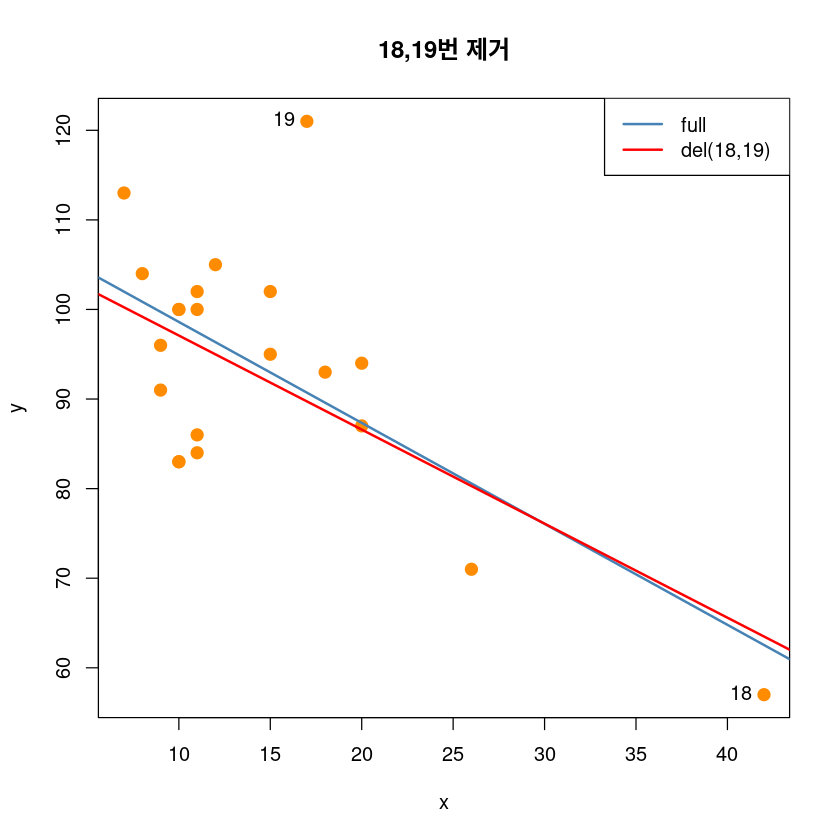

In [43]:
## 18, 19제거 전후
plot(y~x, dt,pch = 20,
 cex = 2,col = "darkorange",
 main = "18,19번 제거")
abline(model_reg, col='steelblue', lwd=2)
abline(lm(y~x, dt[-c(18,19),]), col='red', lwd=2)
text(dt[c(18,19),], pos=2, c("18","19"))
legend('topright', legend=c("full", "del(18,19)"),
 col=c('steelblue', 'red'), lty=1, lwd=2)

# 회귀진단 그림

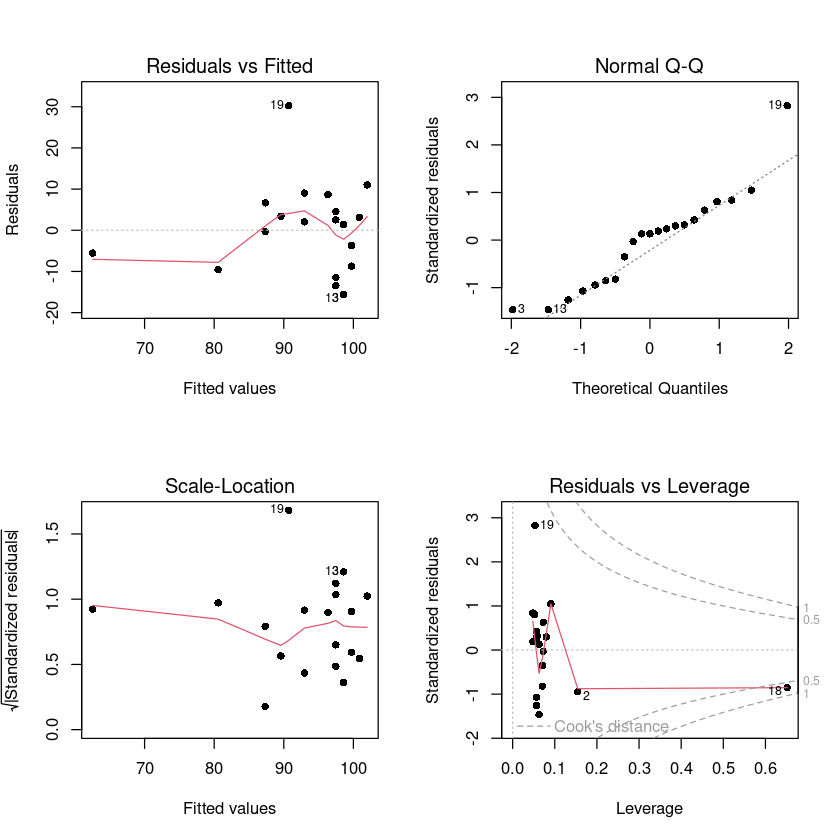

In [44]:
## 회귀진단 그림
par(mfrow = c(2, 2))
plot(model_reg, pch=16)

-   왼쪽위에: $e_i, \hat y_i$그림

-   왼쪽아래: $\sqrt{|r_i|}$

-   오른쪽 아래: 이상치, 영향점, leverage다볼수잇당